# Content-based Filtering

In [2]:
import numpy as np
import pandas as pd

from yanrs.recommenders.content_based_recommender import ContentBasedRecommender
from yanrs.preprocessing.rating_matrix import create_ratings_from_df
from yanrs.metrics.mse_evaluator import mean_squared_error
from yanrs.preprocessing.dataset_splitting import custom_train_test_split
from yanrs.metrics.kendall_evaluator import avg_kendall_per_user_recommendations
from yanrs.metrics.like_dislike_evaluator import like_dislike_f1_score
from yanrs.other.recommendations import get_recommendations_per_user, get_recommended_titles
from yanrs.other.hyperparam_tuning import evaluate_model_per_hyperparams
from yanrs.other.plots import plot_evaluation_scores
from yanrs.other.plots import multi_plot_evaluation_scores
%load_ext autoreload
%autoreload 2

## Data and ratings

In [2]:
np.random.seed(42)

In [3]:
document_df = pd.read_feather("data/active1000_filtered.feather")  # type: ignore

In [4]:
full_rating_matrix, user_mapping, document_mapping = create_ratings_from_df(document_df)


In [5]:
USER_COUNT = full_rating_matrix.shape[0]
DOCUMENT_COUNT = full_rating_matrix.shape[1]
rating_matrix = full_rating_matrix  [:USER_COUNT, :DOCUMENT_COUNT]

In [6]:
train, test = custom_train_test_split(rating_matrix, 0.2)

100%|██████████| 994/994 [00:00<00:00, 7540.14it/s]


Here, the `test` rating matrix contains the ratings for the documents that should be predicted. Thus it is the actual ratings for those documents, and are NaN on the rest of the rated documents in `train`.

## Model, training and prediction

In [7]:
embeddings = np.load(
    # "data/w2v_embeddings.npy"
    # "data/bert_embeddings.npy"
    "data/tfidf_embedding_articles_filtered.npy"
)

In [8]:
cbf = ContentBasedRecommender(embeddings, kmost=100)

In [9]:
cbf.fit(train)

In [ ]:
predictions = cbf.predict_all()

## Recommendations

This gets the documents sorted by their predicted rating. This represents the recommendations for the user.

In [ ]:
recommendations_per_user = get_recommendations_per_user(predictions, test)

In [ ]:
# This is the "correct" recommendations per user
test_recommendations = get_recommendations_per_user(test, test)

### Checking recommendations by example

In [ ]:
user_index = 4

In [ ]:
pred_recommended_titles = get_recommended_titles(recommendations_per_user[user_index], document_mapping, document_df)
pred_recommended_titles


array(['- Denne galskapen må stoppes', 'Listhaug i full korskrangel',
       'Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig, og har fått et nytt liv',
       'Her er superbuss-traseene', 'Dette er ikke Brann verdig!',
       'Meget alvorlig for kvinne (19)',
       'Reagerer sterkt på usikkerhet om campus',
       'Denne professoren avgjør hvem som får status som eliteutdannere i Norge',
       '- Helt greit hvis bensinprisen blir 19-20 kroner',
       'Stargate har kjøpt nytt studio til 43 millioner',
       'Kjente, men dempede toner fra Trump',
       'Dette er RBK-trenerens favoritt til å bli Norges nye landslagstrener',
       'Flere elever fra voldsvideo-episode har blitt midlertidig bortvist fra skole',
       'Arne Scheie om VM-flausen: - Dette var skuffende',
       'Bli med på kjøretur i Trondheim sentrum på 1960-tallet',
       'Her blir Paul-Ottar overrasket på 50-årsdagen',
       'Får bygge på hytte nær vernet vassdrag',


In [ ]:
actual_best_recommended_titles = get_recommended_titles(test_recommendations[user_index], document_mapping, document_df)
actual_best_recommended_titles

array(['- Denne galskapen må stoppes', 'Mobile vanntåkeanlegg redder liv',
       'Listhaug i full korskrangel',
       'Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig, og har fått et nytt liv',
       'Dette er ikke Brann verdig!',
       'Svenskenes dom etter Lagerbäck-debuten: - Klasseforskjell',
       'Reagerer sterkt på usikkerhet om campus',
       'Meget pen selveierleilighet med 2 soverom, 2 bad, stue og stor, sydvendt terrasse - Ski-in fra Hovden - VISNING 28/1 - BoligGuiden - adressa.no',
       'Denne professoren avgjør hvem som får status som eliteutdannere i Norge',
       '- Helt greit hvis bensinprisen blir 19-20 kroner',
       'Stargate har kjøpt nytt studio til 43 millioner',
       'Vintervær igjen midt i uken, betydelig varmere fra helgen',
       'Her slår Norges trener svensken: - Han er usportslig',
       'Dette er RBK-trenerens favoritt til å bli Norges nye landslagstrener',
       '- Fuglene kan flytte på seg'

## Evaluation

### Mean squared error

In [ ]:
mean_squared_error(predictions, test)

0.029380228125489564

### F1 score on like/dislike predictions

In [ ]:
like_dislike_f1_score(predictions, test)

0.6954000263608805

### Average Kendall Tau Correlation coefficient per user recommendations

In [ ]:
avg_kendall_per_user_recommendations(recommendations_per_user, test_recommendations)


-0.004472475111463866

# Hyperparamter tuning

In [ ]:
def set_cbf_hyperparam(model: ContentBasedRecommender, k: int):
    model.kmost = k


k_values = [3,10,20,30,100]

# WARNING: This takes a very long time to run, (about 3 hours)
mse_scores = evaluate_model_per_hyperparams(
    model=ContentBasedRecommender(embeddings, kmost=10),
    train=train, 
    y_true=test, 
    eval_func=mean_squared_error, 
    set_hyperparam=set_cbf_hyperparam,
    hyperparam_values=k_values)

In [ ]:
# Plot the MSE evaluations
plot_evaluation_scores(mse_scores, k_values, "Content-based Filtering", "k", "MSE")

# Result Plots

These are the results plots of the above function. The evaluation scores are directly copied from earlier outputs to avoid running it again as it takes a very long time.

## MSE

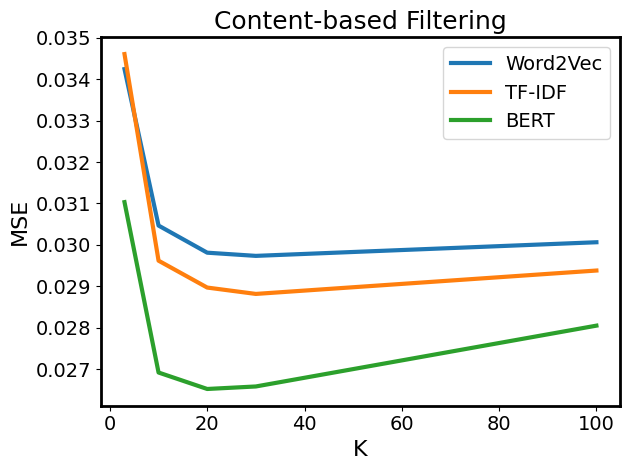

In [ ]:
evaluation_scores = [
    [
        0.034246100048723596,
        0.030466610315778127,
        0.029811397534535083,
        0.02973434440843823,
        0.03006350743944441
    ],
    [
        0.03460833059266836,
        0.029618388012318166,
        0.028969070314470668,
        0.028815358482426397,
        0.029380228125489564
    ],
    [
        0.031032556027663832,
        0.026917159288347637,
        0.026519590104091714,
        0.026580236544970475,
        0.02804922961515561
    ]
]
ks = [3,10,20,30,100]
multi_plot_evaluation_scores(
    ["Word2Vec", "TF-IDF", "BERT"],
    evaluation_scores, ks,
    "Content-based Filtering", "K", "MSE"
)

## F1

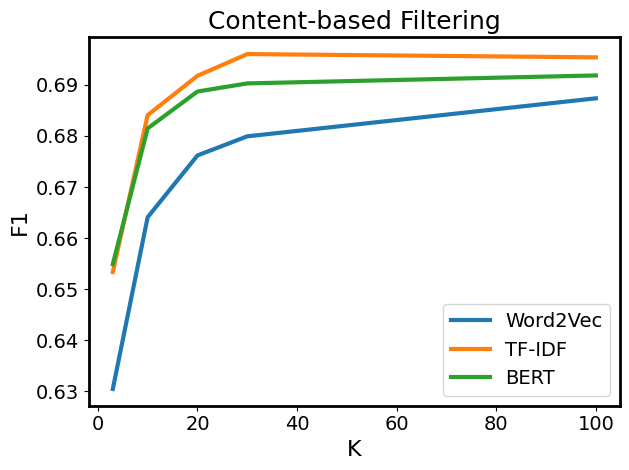

In [ ]:
evaluation_scores = [
    [
        0.6304622379388735,
        0.6640944167044939,
        0.6761900211807049,
        0.6799312053268535,
        0.6873726626522388
    ],
    [
        0.6533566100618949,
        0.6840819052534114,
        0.6917792843352938,
        0.6960374693331352,
        0.6954000263608805
    ],
    [
        0.6549129148866251,
        0.6814833874754752,
        0.6887069020457587,
        0.6902950100878518,
        0.6918544408530645
    ]
]
ks = [3,10,20,30,100]
multi_plot_evaluation_scores(
    ["Word2Vec", "TF-IDF", "BERT"],
    evaluation_scores, ks,
    "Content-based Filtering", "K", "F1"
)

## Kendall-Tau

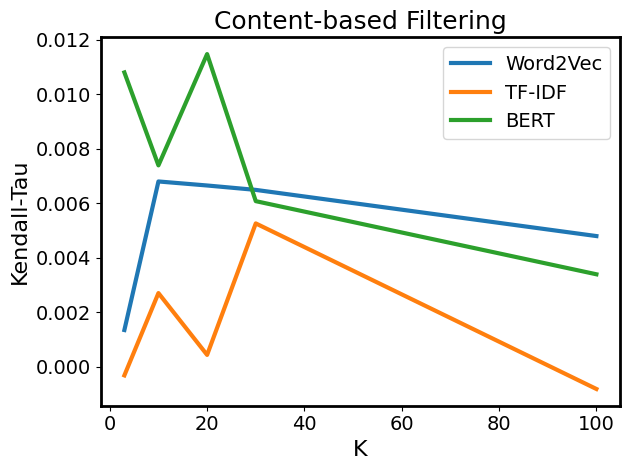

In [3]:
evaluation_scores = [
    [
        0.0013469489334276728,
        0.006796716791634185,
        0.006649058305499122,
        0.006487490089645414,
        0.00479361228078424,
    ],
    [
        -0.0003170006399562418,
        0.0027018932178898424,
        0.00043456296280123543,
        0.00525779124192008,
        -0.0008157116208417503,
    ],
    [
        0.0107961191340489,
        0.007387187684603475,
        0.011469658597109949,
        0.0060745814941563555,
        0.0033915146048404516,
    ],
]
ks = [3, 10, 20, 30, 100]
multi_plot_evaluation_scores(
    ["Word2Vec", "TF-IDF", "BERT"],
    evaluation_scores,
    ks,
    "Content-based Filtering",
    "K",
    "Kendall-Tau",
)